In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# helper functions

In [2]:
def load_imputed_data(donors):
    '''
    Loads (normalized by machine standard) raw data from a list of donors.
    Returns DataFrames in a dictionary.
    '''
    
    df = pd.read_csv('/home/users/mgotsmy/sweat/210000_notebooks/210706_A_train_test_set/train_data/4_with_metadata.csv',index_col=0)
    data = {}
    for donor in donors:
        tmp = df[df['donor']==donor]
        data[donor] = tmp.loc[:,['time','Caffeine','Paraxanthine','Theobromine','Theophylline']]
    
    return data

# def get_fitted_concentration_data(data,donor,sv2):
    
#     x_values = data[donor]['time'].copy()
#     y_values = np.array(data[donor].loc[:,['Caffeine','Paraxanthine','Theobromine','Theophylline']].copy())
#     y_values = y_values.flatten()
    
#     calibration_k = np.array([np.ones(len(x_values))*1.520,np.ones(len(x_values))*1.656,np.ones(len(x_values))*2.050,np.ones(len(x_values))*1.592]).flatten('F')
#     y_values = y_values*calibration_k

#     vsample = 123/1000        # sample volume over 1000 to get to the correct units
#     factor  = vsample
#     y_values = y_values*factor/np.array([sv2,sv2,sv2,sv2]).flatten('F')
    
#     return x_values.astype('float64'), y_values.astype('float64')

def preprocessing_imputed_data(data,donor):
    '''
    Takes raw data dictionary and donor name.
    Parses x_values and y_values.
    Transforms y_values by calibration curve.
    Assigns 10**8 sigma values (= weights) to all 0s because they are below LOQ and thus regarded as NaNs.
    Returns x_values, sigma, y_values as float64 np.arrays.
    '''
    
    x_values = data[donor]['time'].copy()
    y_values = np.array(data[donor].loc[:,['Caffeine','Paraxanthine','Theobromine','Theophylline']].copy())
    y_values = y_values.flatten()
    
    # apply calibration curve
    calibration_k = np.array([np.ones(len(x_values))*1.520,np.ones(len(x_values))*1.656,np.ones(len(x_values))*2.050,np.ones(len(x_values))*1.592]).flatten('F')
    y_values      = y_values*calibration_k

    # pharmacological factors
    vdist_avail = 0.579                                        # volume of distribution/ bioavailability of caffeine
    vsample     = 123                                          # sample volume in µL
    dose        = 200*10**3                                    # caffeine dose in µg
    body_mass   = {'Donor_16': 72, 'Donor_6': 83, 'Donor_19': 83, 'Donor_17': 52, 'Donor_18': 66, 'Donor_7': 66, 'Donor_3': 57, 'Donor_4': 84, 'Donor_5': 82.5, 'Donor_2': 77, 'Donor_8': 80, 'Donor_9': 83, 'Donor_10': 55, 'Donor_11': 54, 'Donor_1': 70, 'Donor_20': 105, 'Donor_21': 70, 'Donor_22': 64, 'Donor_23': 57, 'Donor_24': 60, 'Donor_25': 80, 'Donor_26': 86, 'Donor_27': 68, 'Donor_28': 82, 'Donor_29': 60, 'Donor_30': 55, 'Donor_31': 80, 'Donor_32': 92, 'Donor_33': 92, 'Donor_34': 71, 'Donor_35': 80, 'Donor_36': 77, 'Donor_37': 66, 'Donor_38': 63, 'Donor_39': 75, 'Donor_40': 75, 'Donor_41': 57, 'Donor_42': 75, 'Donor_43': 99, 'Donor_44': 75, 'Donor_45': 61, 'Donor_46': 52, 'Donor_47': 80}
    factor      = vsample*body_mass[donor]*vdist_avail/dose
    y_values    = y_values*factor
    
    # applying lambda 
    sigma   = []
    lambda_ = 1/(4+1)
    concentration_sigma = np.ones(len(y_values))/lambda_
    y_values = np.concatenate([y_values])
    s_values = np.concatenate([concentration_sigma]) 

    return x_values.astype('float64'), y_values.astype('float64'), s_values.astype('float64')

def caf(tt,k1,k2,k3,k4,k5,k6,k7,k8,par0,bro0,phy0):
    '''Takes timepoints and kinetic parameters, calculates concentration time series of caffeine.'''
    k9 = k2+k3+k4+k5
    y = k1/(k9-k1)*(np.exp(-k1*tt)-np.exp(-k9*tt))
    return y

def par(tt,k1,k2,k3,k4,k5,k6,k7,k8,par0,bro0,phy0):
    '''Takes timepoints and kinetic parameters, calculates concentration time series of paraxanthine.'''
    k9 = k2+k3+k4+k5
    y = k1*k2/(k9-k1)*(np.exp(-k9*tt)/(k9-k6)-np.exp(-k1*tt)/(k1-k6)+np.exp(-k6*tt)*(k9-k1)/((k9-k6)*(k1-k6)))+par0*np.exp(-k6*tt)
    return y

def bro(tt,k1,k2,k3,k4,k5,k6,k7,k8,par0,bro0,phy0):
    '''Takes timepoints and kinetic parameters, calculates concentration time series of theobromine.'''
    k9 = k2+k3+k4+k5
    y = k1*k3/(k9-k1)*(np.exp(-k9*tt)/(k9-k7)-np.exp(-k1*tt)/(k1-k7)+np.exp(-k7*tt)*(k9-k1)/((k9-k7)*(k1-k7)))+bro0*np.exp(-k7*tt)
    return y

def phy(tt,k1,k2,k3,k4,k5,k6,k7,k8,par0,bro0,phy0):
    '''Takes timepoints and kinetic parameters, calculates concentration time series of theophylline.'''
    k9 = k2+k3+k4+k5
    y = k1*k4/(k9-k1)*(np.exp(-k9*tt)/(k9-k8)-np.exp(-k1*tt)/(k1-k8)+np.exp(-k8*tt)*(k9-k1)/((k9-k8)*(k1-k8)))+phy0*np.exp(-k8*tt)
    return y

def fit_with_sv(tt,kcincaf,kcafpar,kcafbro,kcafphy,kcafdeg,kpardeg,kbrodeg,kphydeg,par0,bro0,phy0,*sfs):
    '''
    This function takes timepoints (tt) and all fitting parameters and calculates original values (c*V_sweat) with it. 
    '''
    
    # global_args and global_timepoints are needed for the calculation of relative fitting error
    global global_args, global_timepoints, global_sfs
    args = [kcincaf,kcafpar,kcafbro,kcafphy,kcafdeg,kpardeg,kbrodeg,kphydeg,par0,bro0,phy0]
    global_args = args
    global_timepoints = tt
    global_sfs = sfs
    
    # calculated c*V_sweat
    caf_true = np.array(caf(tt,*args))*np.array(sfs)
    par_true = np.array(par(tt,*args))*np.array(sfs)
    bro_true = np.array(bro(tt,*args))*np.array(sfs)
    phy_true = np.array(phy(tt,*args))*np.array(sfs)
    y = np.array([caf_true,par_true,bro_true,phy_true])
    y = np.concatenate([y.flatten('F')])
    return y    

# variance of biological replicates

# sub2 analysis

In [21]:
# parameter properties
parameter_names = ['x','k1','k2','k3','k4','k5','k6','k7','k8','cpar0','cbro0','cphy0','vsweat1','vsweat2','vsweat3','vsweat4','vsweat5','vsweat6','vsweat7','vsweat8','vsweat9','vsweat10','vsweat11','vsweat12','vsweat13','vsweat14','vsweat15','vsweat16','vsweat17','vsweat18','vsweat19','vsweat20','vsweat21','vsweat22','vsweat23','vsweat24']
parameter_units = ['[]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[unitless]','[unitless]','[unitless]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]']
donors = ['Donor_1', 'Donor_10', 'Donor_16', 'Donor_17', 'Donor_18', 'Donor_19', 'Donor_2', 'Donor_20', 'Donor_21', 'Donor_22', 'Donor_23', 'Donor_24', 'Donor_25', 'Donor_26', 'Donor_27', 'Donor_28', 'Donor_29', 'Donor_3', 'Donor_30', 'Donor_31', 'Donor_32', 'Donor_33', 'Donor_34', 'Donor_35', 'Donor_36', 'Donor_37', 'Donor_38', 'Donor_39', 'Donor_4', 'Donor_40', 'Donor_41', 'Donor_42', 'Donor_43', 'Donor_44', 'Donor_45', 'Donor_46', 'Donor_47', 'Donor_5', 'Donor_7', 'Donor_8', 'Donor_9']
metabolites = ['Paraxanthine','Theobromine','Theophylline']
def parse_results(path):
    best_parameters = {}
    for donor in donors:
        tmp_dic = {}
        for metabolite in metabolites:
            # read in file from the output data that was used in the manuscript
            with open(f'./{path}/{donor}_{metabolite}.txt','r') as file:
                lines  = file.readlines()
            parameters = []
            losses     = []
            for line in lines:
                tmp = []
                for l in line.split()[0:-1]:
                    tmp.append(float(l))
                parameters.append(tmp)
                losses.append(float(line.split()[-1]))

            # select fit with lowest loss
            if 'MIX' in path:
                best = parameters[np.argmin(losses)][1:]
            elif 'EM' in path:
                best = parameters[np.argmin(losses)]
            else:
                print('Parsing Error, could not identify model type. \n Either MIX or EM should be in path.')
            tmp_dic[metabolite] = best
        best_parameters[donor] = tmp_dic
    return best_parameters

best_parameters = parse_results('EM_sub_2')
print('done')

done


In [7]:
def get_stds(path,verbose=True):
    best_parameters = parse_results(path)
    stds = []
    for donor in donors:
        k = []
        for metabolite in metabolites:
            tmp = best_parameters[donor][metabolite]
            ka = tmp[0]
            ke = tmp[1]+tmp[2]
            k.append([ka,ke])
        k = np.array(k)
        stds.append(np.std(k,axis=0))
    stds = np.array(stds)
    if verbose:
        print(np.mean(stds,axis=0))
        print(np.std( stds,axis=0))
    return stds

In [22]:
def get_stds(path,verbose=True):
    best_parameters = parse_results(path)
    stds = []
    for donor in donors:
        k = []
        for metabolite in metabolites:
            tmp = best_parameters[donor][metabolite]
            ka = tmp[0]
            ke = tmp[1]+tmp[2]
            k.append([ka,ke])
        k = np.array(k)
        stds.append(np.std(k,axis=0))
    stds = np.array(stds)
    if verbose:
        print('      ka         ke')
        print('mean',np.mean(stds,axis=0))
        print('std ',np.std( stds,axis=0))
    return stds

from itertools import combinations
import scipy.stats as ss

def calculate_significances(tmp_dic,tmp_loc):
    # significances
    maximum = 0
    for key in tmp_dic:
        if np.max(tmp_dic[key]) > maximum:
            maximum = np.max(tmp_dic[key])
    height          = maximum*1.1
    bracket_size    = .01
    text_offset     = .01
    height_increase = .05*maximum
    print('------- P VALUES ------')
    for i,j in combinations(tmp_dic.keys(),2):
        test_result = ss.mannwhitneyu(tmp_dic[i],tmp_dic[j])
        print('{:15} {:15} {:.2e}'.format(i,j,test_result.pvalue))
        if test_result.pvalue <= .05:
                plt.plot(np.array([tmp_loc[i],tmp_loc[i],tmp_loc[j],tmp_loc[j]]),
                         [height-maximum*bracket_size,height,height,height-maximum*bracket_size],
                         'k',
                         linewidth=.5
                        )
                plt.text(np.mean([tmp_loc[i],tmp_loc[j]]),
                         height+maximum*text_offset,
                         significance_star(test_result.pvalue),
                         ha='center',
                         va='center',
                         fontsize=8
                        )
                height += height_increase
                
def significance_star(pvalue):
    '''
    Prints correct number of stars for the significance level.
    -
    Input
    pvalue      value of probability
    -
    Output      
    string      string with correct number of stars for significant results and - for no significance
    '''
    
    assert pvalue >= 0
    
    if pvalue <= .001:
        return '***'
    elif pvalue <= .01:
        return '**'
    elif pvalue <= .05:
        return '*'
    else:
        return '-'

EM_sub_2
      ka         ke
mean [0.8902591  0.01195976]
std  [1.06852976 0.00841451]
MIX_sub_2_n_EM
      ka         ke
mean [0.47589578 0.00686631]
std  [0.65926382 0.00477243]
MIX_sub_2_n_PQN
      ka         ke
mean [0.5990715  0.00751941]
std  [0.99017836 0.00811413]
------- P VALUES ------
EM_sub_2        MIX_sub_2_n_EM  1.35e-01
EM_sub_2        MIX_sub_2_n_PQN 7.20e-02
MIX_sub_2_n_EM  MIX_sub_2_n_PQN 2.58e-01
------- P VALUES ------
EM_sub_2        MIX_sub_2_n_EM  2.58e-03
EM_sub_2        MIX_sub_2_n_PQN 2.28e-03
MIX_sub_2_n_EM  MIX_sub_2_n_PQN 5.59e-01


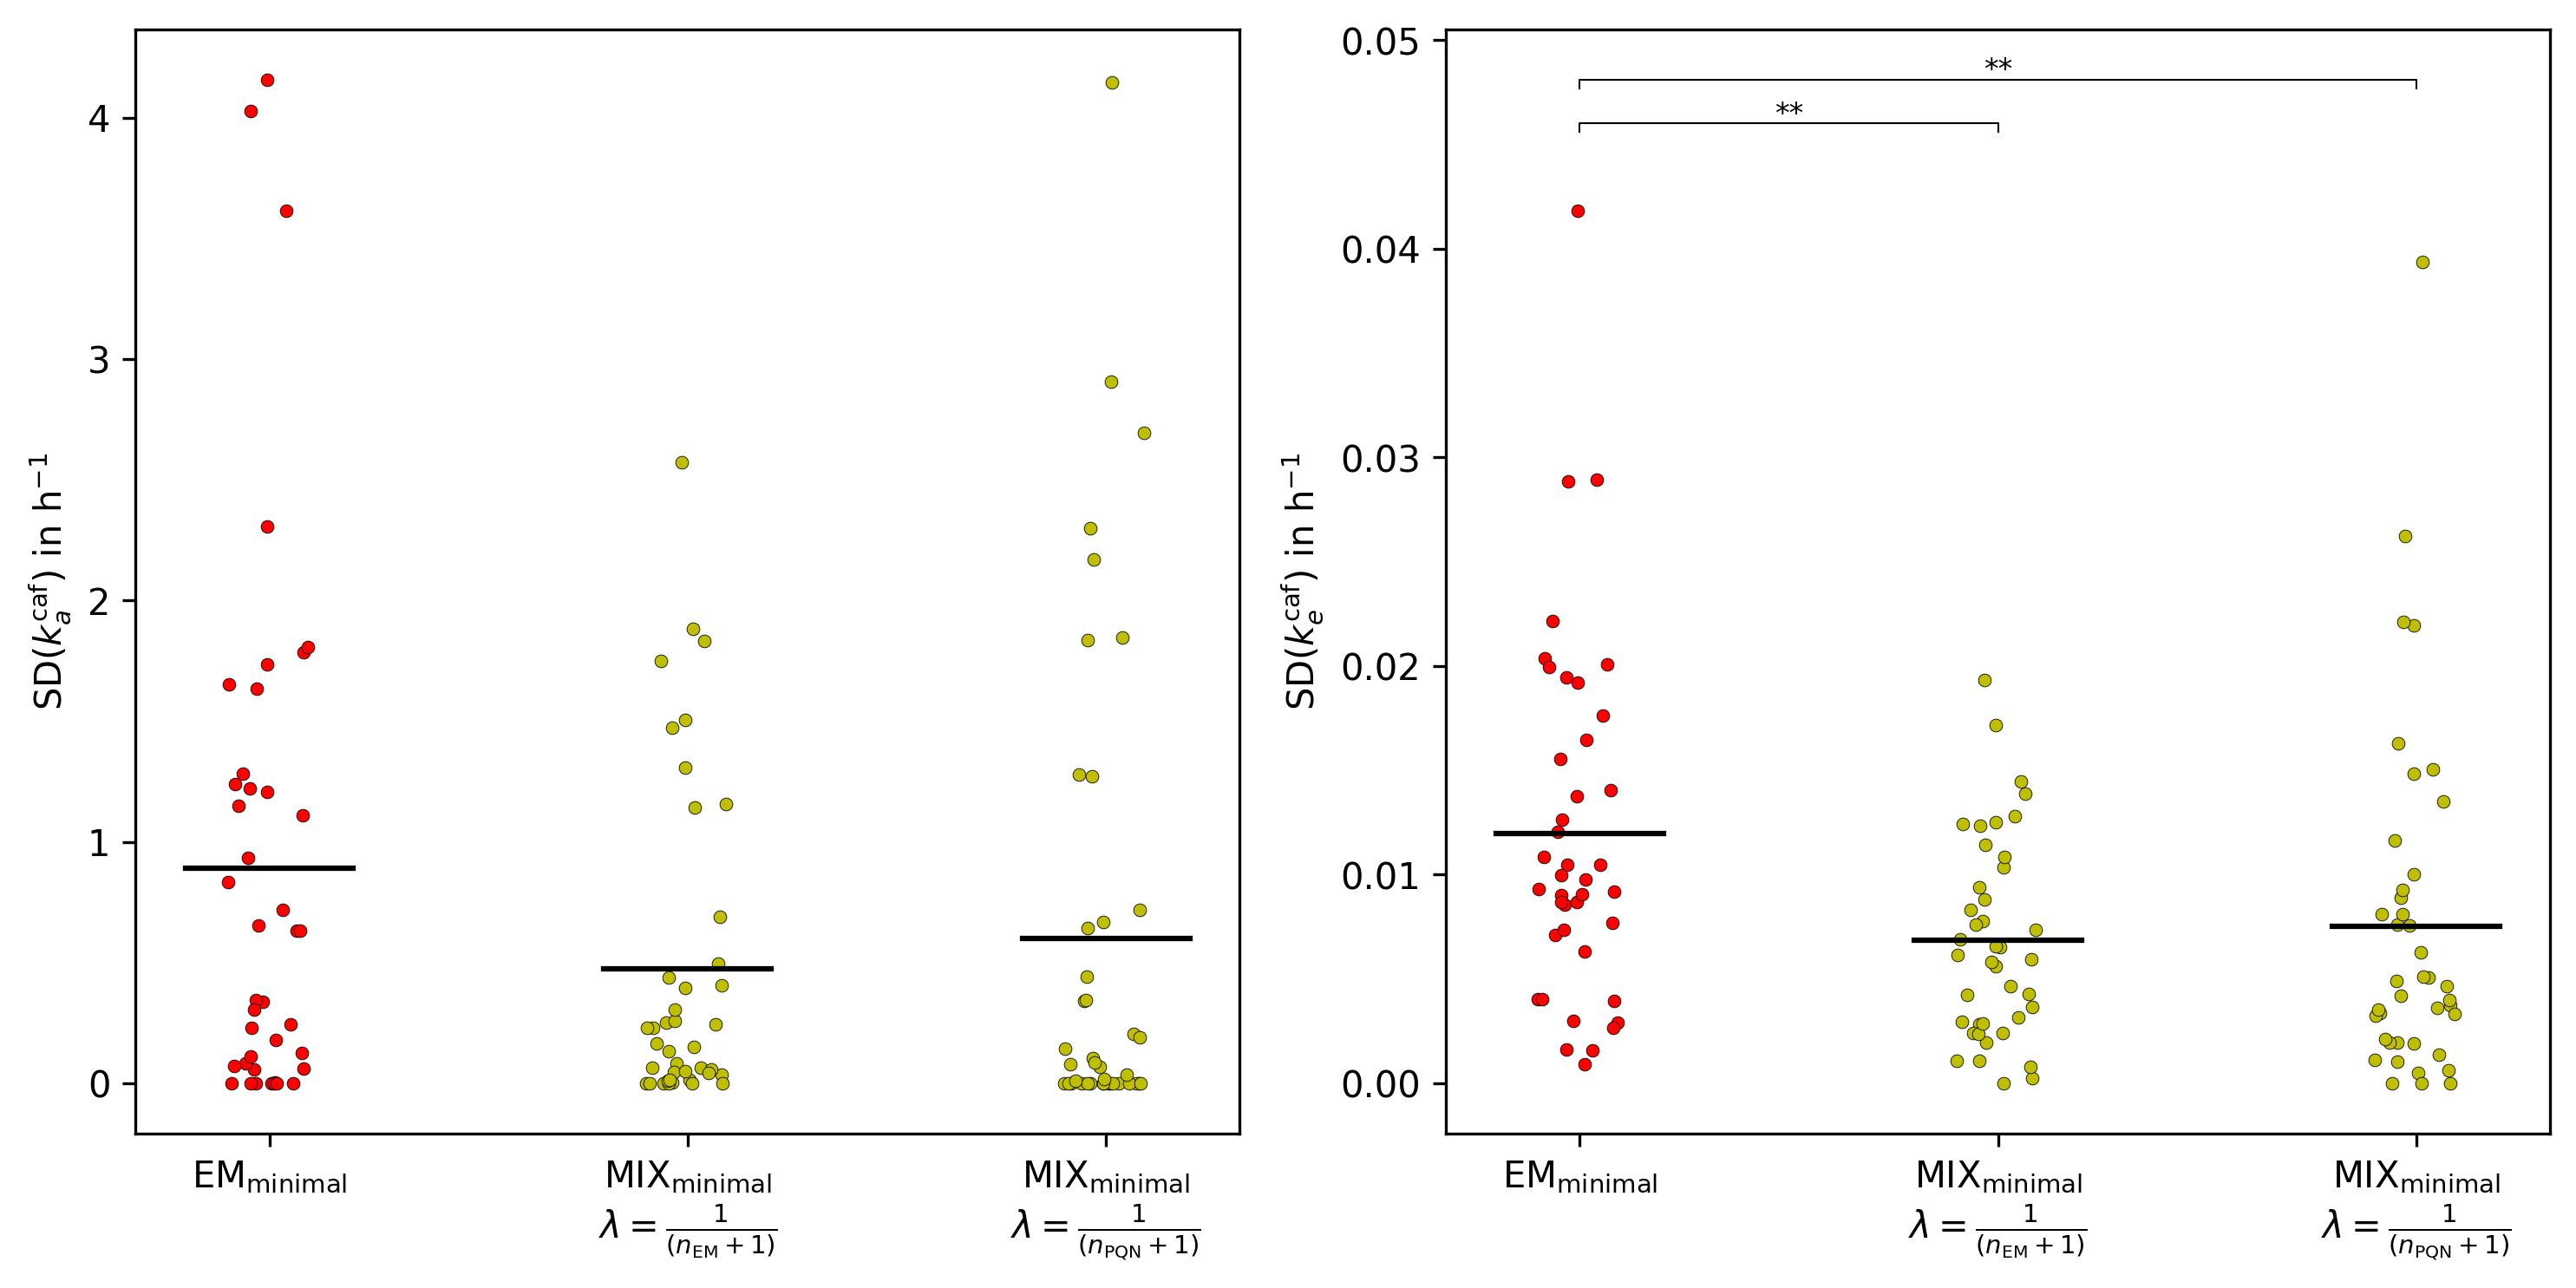

In [23]:
width = .1

path_list  = ['EM_sub_2','MIX_sub_2_n_EM','MIX_sub_2_n_PQN']
label_list = [r'EM$_{\rm minimal}$',r'MIX$_{\rm minimal}$'+'\n'+r'$\lambda = \frac{1}{(n_{\rm EM}+1)}$',r'MIX$_{\rm minimal}$'+'\n'+r'$\lambda = \frac{1}{(n_{\rm PQN}+1)}$']
color_list = ['r','y','y','y']

# parse data
s_list = []
for path in path_list:
    print(path)
    s_list.append(get_stds(path))

# generate random numbers to make the datapoints more spread out
rand = np.random.uniform(-width,width,s_list[0].shape[0])

# start figure
plt.figure(dpi=300,figsize=(10,5))

# subplot 1: ka
plt.subplot(121,box_aspect=1)
plt.ylabel(r'SD($k_a^{\rmcaf}$) in h$^{-1}$')
tmp_dic = {}
tmp_loc = {}
for nr in range(len(path_list)):
    tmp_s = s_list[nr]
    plt.scatter(np.ones(tmp_s.shape[0])*nr+rand,tmp_s[:,0], marker='.',s=50,edgecolor='k',linewidth=.2,color=color_list[nr])
    plt.plot([nr-.2,nr+.2], [np.mean(tmp_s[:,0]), np.mean(tmp_s[:,0])],color='k')
    tmp_dic[path_list[nr]] = tmp_s[:,0]
    tmp_loc[path_list[nr]] = nr
calculate_significances(tmp_dic,tmp_loc)
plt.xticks(range(len(path_list)),label_list)

# subplot 2: ke
plt.subplot(122,box_aspect=1)
plt.ylabel(r'SD($k_e^{\rmcaf}$) in h$^{-1}$')
tmp_dic = {}
tmp_loc = {}
for nr in range(len(path_list)):
    tmp_s = s_list[nr]
    plt.scatter(np.ones(tmp_s.shape[0])*nr+rand,tmp_s[:,1], marker='.',s=50,edgecolor='k',linewidth=.2,color=color_list[nr])
    plt.plot([nr-.2,nr+.2], [np.mean(tmp_s[:,1]), np.mean(tmp_s[:,1])],color='k')
    tmp_dic[path_list[nr]] = tmp_s[:,1]
    tmp_loc[path_list[nr]] = nr
calculate_significances(tmp_dic,tmp_loc)
plt.xticks(range(len(path_list)),label_list)

# wrap up
plt.tight_layout()
plt.show()